Let's get started, as before, with importing the necessary libraries and defining the environment.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy.typing as npt
import typing
import gymnasium as gym
from dataclasses import dataclass
from metadrive.envs.top_down_env import TopDownMetaDrive
gym.register(id="MetaDrive-topdown", entry_point=TopDownMetaDrive, kwargs=dict(config={}))


Successfully registered the following environments: ['MetaDrive-validation-v0', 'MetaDrive-10env-v0', 'MetaDrive-100envs-v0', 'MetaDrive-1000envs-v0', 'SafeMetaDrive-validation-v0', 'SafeMetaDrive-10env-v0', 'SafeMetaDrive-100envs-v0', 'SafeMetaDrive-1000envs-v0', 'MARLTollgate-v0', 'MARLBottleneck-v0', 'MARLRoundabout-v0', 'MARLIntersection-v0', 'MARLParkingLot-v0', 'MARLMetaDrive-v0'].


In [2]:
def collect_trajectory(env:gym.Env, policy:typing.Callable[[npt.NDArray], int]) -> tuple[list[npt.NDArray], list[int], list[float]]:
    """
    Collect a trajectory from the environment using the given policy
    """
    observations = []
    actions = []
    rewards = []
    obs, info = env.reset()
    
    while True:
        observations.append(obs)
        action = policy(obs)
        actions.append(action)
        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        if terminated or truncated:
            break

    return observations, actions, rewards

In [3]:
def deviceof(m: nn.Module) -> torch.device:
    """
    Get the device of the given module
    """
    return next(m.parameters()).device

In [4]:
def obs_batch_to_tensor(obs: list[npt.NDArray[np.float32]], device: torch.device) -> torch.Tensor:
    """
    Reshape the image observation from (B, H, W, C) to (B, C, H, W) and convert it to a tensor
    """
    return torch.tensor(np.stack(obs), dtype=torch.float32, device=device).permute(0, 3, 1, 2)

In [5]:
# actor network
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        # input is size 84x84x5
        # output is size 2
        self.conv1 = nn.Conv2d(5, 16, kernel_size=8, stride=4) # 84x84x5 -> 20x20x16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2) # 20x20x16 -> 9x9x32
        self.fc1 = nn.Linear(9*9*32, 256) # 9x9x32 -> 256
        self.fc2 = nn.Linear(256, 2) # 256 -> 2

    def forward(self, x: torch.Tensor) -> torch.distributions.MultivariateNormal:
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        mu = torch.tanh(self.fc2(x))
        # sigma is fixed at 0.05
        sigma = 0.05*torch.ones_like(mu)
        return torch.distributions.MultivariateNormal(mu, torch.diag_embed(sigma))

In [6]:
# critic network
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        # input is size 84x84x5
        # output is size 1
        self.conv1 = nn.Conv2d(5, 16, kernel_size=8, stride=4) # 84x84x5 -> 20x20x16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2) # 20x20x16 -> 9x9x32
        self.fc1 = nn.Linear(9*9*32, 256) # 9x9x32 -> 256
        self.fc2 = nn.Linear(256, 1) # 256 -> 1

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x)) # Bx84x84x5 -> Bx20x20x16
        x = F.relu(self.conv2(x)) # Bx20x20x16 -> Bx9x9x32
        x = torch.flatten(x, start_dim=1) # Bx9x9x32 -> Bx9*9*32
        x = F.relu(self.fc1(x)) # Bx9*9*32 -> Bx256
        x = self.fc2(x) # Bx256 -> Bx1
        output = torch.squeeze(x, dim=1) # Bx1 -> B
        return output

In [7]:
def nn_policy(net:Actor, obs:npt.NDArray[np.float32]) -> tuple[float, float]:
    """
    A neural network policy that returns an action based on the given observation
    """
    # convert observation to a tensor
    obs_tensor = obs_batch_to_tensor([obs], deviceof(net))
    # sample from the policy network
    throttle, steer = net(obs_tensor).sample().squeeze(0)
    return throttle.item(), steer.item()

In [8]:
def rewards_to_go(trajectory_rewards: list[float], gamma) -> list[float]:
    """
    Computes the gamma discounted reward-to-go for each state in the trajectory.
    """

    trajectory_len = len(trajectory_rewards)

    v_batch = np.zeros(trajectory_len)

    v_batch[-1] = trajectory_rewards[-1]

    # Use gamma to decay the advantage
    for t in reversed(range(trajectory_len - 1)):
        v_batch[t] = trajectory_rewards[t] + gamma * v_batch[t + 1]

    return list(v_batch)

In [9]:
def compute_advantage(
    critic: Critic,
    trajectory_observations: list[npt.NDArray[np.float32]],
    trajectory_rewards: list[float],
    gamma: float
) -> list[float]:
    """
    Computes advantage using GAE.

    See here for derivation: https://arxiv.org/abs/1506.02438
    """

    trajectory_len = len(trajectory_rewards)

    assert len(trajectory_observations) == trajectory_len
    assert len(trajectory_rewards) == trajectory_len

    # calculate the value of each state
    obs_tensor = obs_batch_to_tensor(trajectory_observations, deviceof(critic))
    obs_values = critic.forward(obs_tensor).detach().cpu().numpy()

    # subtract the obs_value from the rewards-to-go
    trajectory_advantages = np.array(rewards_to_go(trajectory_rewards, gamma)) # - obs_values

    return list(trajectory_advantages)

In [10]:
@dataclass
class PPOConfig:
    ppo_eps: float
    ppo_grad_descent_steps: int

def compute_ppo_loss(
    # Old policy network's distribution of actions given a state
    # inner shape = (Batch, 2)
    pi_thetak_given_st: torch.distributions.MultivariateNormal,
    # Current policy network's distribution of actions given a state
    # in (Batch, Action)
    pi_theta_given_st: torch.distributions.MultivariateNormal,
    # The action chosen by the old policy network
    # in (Batch, 2)
    a_t: torch.Tensor,
    # Advantage of the chosen action
    # in (Batch,)
    A_pi_thetak_given_st_at: torch.Tensor,
    # configuration options
    config: PPOConfig
) -> torch.Tensor:
    # in (Batch,)
    pi_theta_given_st_at = torch.exp(pi_theta_given_st.log_prob(a_t))
    pi_thetak_given_st_at = torch.exp(pi_thetak_given_st.log_prob(a_t))

    # the likelihood ratio (used to penalize divergence from the old policy)
    likelihood_ratio = pi_theta_given_st_at / pi_thetak_given_st_at

    # in (Batch,)
    ppo_loss_per_example = -torch.minimum(
        likelihood_ratio * A_pi_thetak_given_st_at,
        torch.clip(likelihood_ratio, 1 - config.ppo_eps, 1 + config.ppo_eps) * A_pi_thetak_given_st_at,
    )

    loss_per_example = ppo_loss_per_example

    # we take the average loss over all examples
    return loss_per_example.mean()


def train_ppo(
    actor: Actor,
    critic: Critic,
    actor_optimizer: torch.optim.Optimizer,
    critic_optimizer: torch.optim.Optimizer,
    observation_batch: list[npt.NDArray[np.float32]],
    action_batch: list[tuple[float, float]],
    advantage_batch: list[float],
    reward_to_go_batch: list[float],
    config: PPOConfig
) -> tuple[list[float], list[float]]:
    # assert that the models are on the same device
    assert deviceof(critic) == deviceof(actor)
    # assert that the batch_lengths are the same
    assert len(observation_batch) == len(action_batch)
    assert len(observation_batch) == len(advantage_batch)
    assert len(observation_batch) == len(reward_to_go_batch)

    # get device
    device = deviceof(critic)

    # convert data to tensors on correct device

    # in (Batch, Width, Height)
    observation_batch_tensor = obs_batch_to_tensor(observation_batch, device)

    # the true V^pi(s) is reward to go
    # in (Batch,)
    true_value_batch_tensor = torch.tensor(
        reward_to_go_batch, dtype=torch.float32, device=device
    )

    # in (Batch, 2)
    chosen_action_tensor = torch.tensor(action_batch, device=device)

    # in (Batch,)
    advantage_batch_tensor = torch.tensor(advantage_batch, device=device)

    # train critic
    critic_optimizer.zero_grad()
    pred_value_batch_tensor = critic.forward(observation_batch_tensor)
    critic_loss = F.mse_loss(pred_value_batch_tensor, true_value_batch_tensor)
    critic_loss.backward()
    critic_optimizer.step()

    # train actor

    # Recall that in the PPO algorithm, we need to set theta to the *optimal* theta with respect to the surrogate loss function,
    # as opposed to the standard policy gradient, where we just update theta.

    # Here's what that means:
    # We have a policy network with parameters theta_k
    # We want to find the optimal theta, theta*, that maximizes the surrogate loss function L_CLIP(theta, theta_k)
    # Note: In practice, we just use gradient descent for PPO_GRAD_DESCENT_STEPS steps to approximate theta*, since we can't analytically solve for theta*
    # We then update: theta_k <- theta*

    # The amount theta* can diverge from theta_k is limited by L_CLIP(theta, theta_k).
    # This is because we want to avoid the new policy diverging too far from the old policy, since that can lead to instability.

    # the old_policy_action_probs are the the predictions made by the pre-train-step network that we want to not diverge too far away from
    # in (Batch, Action)
    with torch.no_grad():
        old_policy_action_probs = actor.forward(observation_batch_tensor)

    actor_losses = []
    for _ in range(config.ppo_grad_descent_steps):
        actor_optimizer.zero_grad()
        current_policy_action_probs = actor.forward(observation_batch_tensor)
        actor_loss = compute_ppo_loss(
            old_policy_action_probs,
            current_policy_action_probs,
            chosen_action_tensor,
            advantage_batch_tensor,
            config
        )
        actor_loss.backward()
        actor_optimizer.step()
        actor_losses.append(float(actor_loss))


    # return the respective losses
    return actor_losses, [float(critic_loss)]*config.ppo_grad_descent_steps

In [11]:
# disable logging from metadrive
import logging
import inspect
import metadrive.envs.base_env
logging.getLogger(inspect.getfile(metadrive.envs.base_env)).setLevel(logging.WARNING)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

actor  = Actor().to(device)
critic = Critic().to(device)

step = 0
returns = []
actor_losses = []
critic_losses = []

In [32]:
env = gym.make("MetaDrive-topdown", config={"use_render": False, "horizon": 200, "num_scenarios": 100})

In [54]:
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=1e-5)
# the critic has to learn faster than the actor
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=1e-3)

TRAIN_EPOCHS = 150
EPISODES_PER_BATCH = 32
GAMMA = 0.85
CONFIG = PPOConfig(
    ppo_eps=0.1,
    ppo_grad_descent_steps=20,
)

# Train
while step < TRAIN_EPOCHS:
    obs_batch:list[npt.NDArray[np.float32]] = []
    act_batch:list[int] = []
    rtg_batch:list[float] = []
    adv_batch:list[float] = []
    
    trajectory_returns = []

    for _ in range(EPISODES_PER_BATCH):
        # Collect trajectory
        obs_traj, act_traj, rew_traj = collect_trajectory(env, lambda obs: nn_policy(actor, obs))
        rtg_traj = rewards_to_go(rew_traj, GAMMA)
        adv_traj = compute_advantage(critic, obs_traj, rew_traj, GAMMA)

        # Update batch
        obs_batch.extend(obs_traj)
        act_batch.extend(act_traj)
        rtg_batch.extend(rtg_traj)
        adv_batch.extend(adv_traj)

        # Update trajectory returns
        trajectory_returns.append(sum(rew_traj))

    batch_actor_losses, batch_critic_losses = train_ppo(
        actor,
        critic,
        actor_optimizer,
        critic_optimizer,
        obs_batch,
        act_batch,
        adv_batch,
        rtg_batch,
        CONFIG,
    )

    # collect statistics
    returns.append(trajectory_returns)
    actor_losses.extend(batch_actor_losses)
    critic_losses.extend(batch_critic_losses)

    print(f"Step {step}, Avg. Returns: {np.mean(trajectory_returns):.3f} +/- {np.std(trajectory_returns):.3f}, Median: {np.median(trajectory_returns):.3f}, Actor Loss: {actor_losses[-1]:.3f}, Critic Loss: {batch_critic_losses[-1]:.3f}")

    step += 1

In [34]:
env.close()

Let's look at how the policy drives:

In [55]:
env = gym.make("MetaDrive-topdown", config={"use_render": True, "horizon": 500, "num_scenarios": 100})
obs, act, rew = collect_trajectory(env, lambda obs: nn_policy(actor, obs))
env.close()

print("Reward:", sum(rew))

Known pipe types:
  glxGraphicsPipe
(1 aux display modules not yet loaded.)
:task(warning): Creating implicit AsyncTaskChain default for AsyncTaskManager TaskManager


Reward: 99.81116466438984


: 

For us, we got returns of around 60-70 after training for 100 epochs.

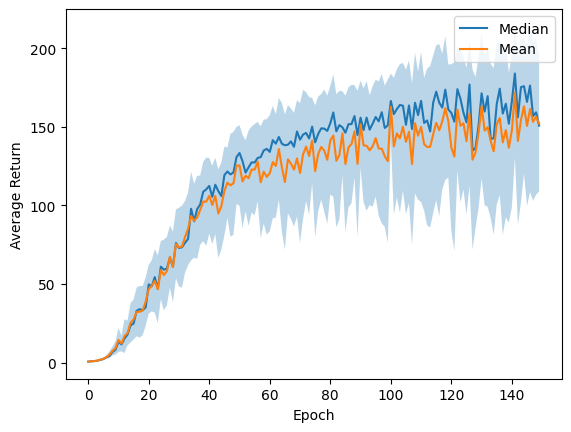

In [35]:
import matplotlib.pyplot as plt
return_medians = [np.median(returns[i]) for i in range(len(returns))]
return_means = [np.mean(returns[i]) for i in range(len(returns))]
return_stds = [np.std(returns[i]) for i in range(len(returns))]
plt.plot(return_medians, label="Median")
plt.plot(return_means, label="Mean")
plt.fill_between(range(len(return_means)), np.array(return_means) - np.array(return_stds), np.array(return_means) + np.array(return_stds), alpha=0.3)
plt.xlabel("Epoch")
plt.ylabel("Average Return")
plt.legend()
plt.show()

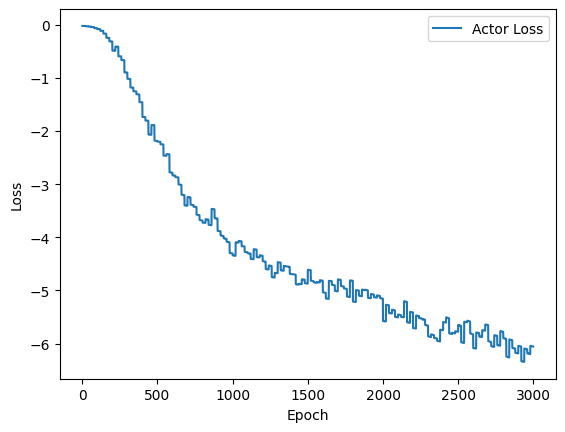

In [36]:
# plot actor losses
plt.plot(actor_losses, label="Actor Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

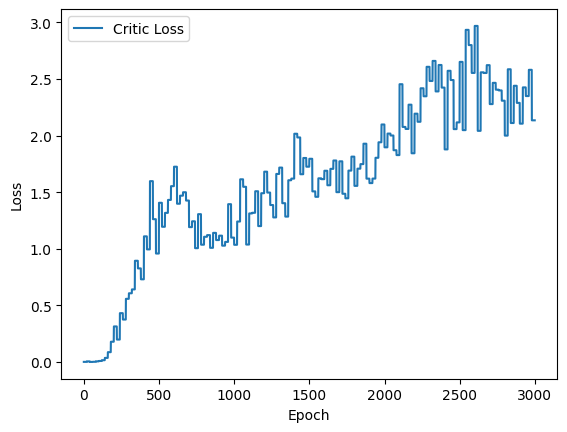

In [37]:
# plot critic losses
plt.plot(critic_losses, label="Critic Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

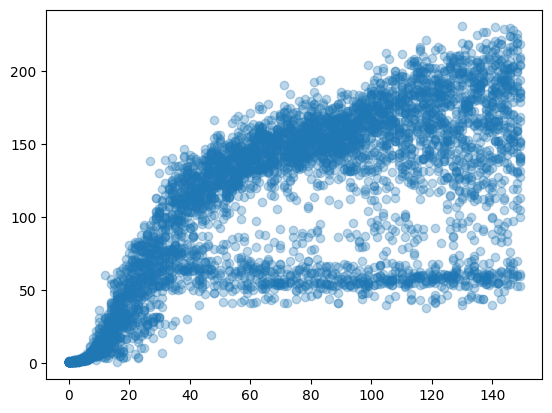

In [39]:
# scatter plot of the returns
xs = []
ys = []
for t, rets in enumerate(returns):
    for ret in rets:
        xs.append(t)
        ys.append(ret)
plt.scatter(xs, ys, alpha=0.3)

In [40]:
# print actual reward-to-go
print(np.array(rtg_traj))
# print predicted reward-to-go
print(critic.forward(obs_batch_to_tensor(obs_traj, deviceof(critic))).squeeze().detach().cpu().numpy())


[ 0.62445545  0.73433491  0.85021448  0.95919773  1.06263166  1.16052561
  1.26383556  1.37596659  1.48513745  1.59143308  1.69672033  1.79859093
  1.89595432  1.99315256  2.09380144  2.18501944  2.27074688  2.3574902
  2.45441354  2.56398137  2.67022717  2.77575037  2.87735082  2.98041589
  3.07931153  3.16807435  3.2565743   3.34338185  3.4309192   3.51723411
  3.59753566  3.67711279  3.7589094   3.8482935   3.93093028  4.01817656
  4.11996356  4.21565248  4.31222312  4.40641316  4.4895532   4.56984225
  4.65422489  4.733612    4.8086472   4.87658202  4.94681158  5.02887122
  5.10863696  5.18787453  5.26742751  5.34571543  5.42219315  5.50250247
  5.58172203  5.66650278  5.75019611  5.83810364  5.93590852  6.02648451
  6.11310154  6.19583955  6.28234489  6.37002474  6.44954486  6.53744121
  6.61991283  6.69817627  6.76960355  6.8351545   6.89752501  6.9505504
  7.01213586  7.08440159  7.15371667  7.22876951  7.30980326  7.39185831
  7.4626382   7.52442625  7.57995862  7.63158104  7.6

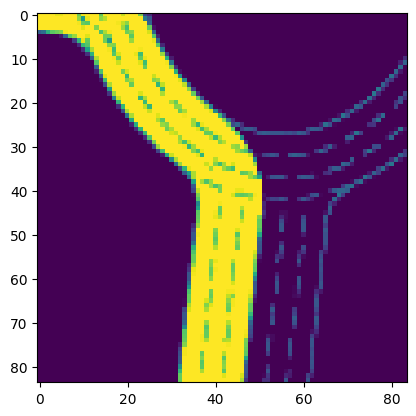

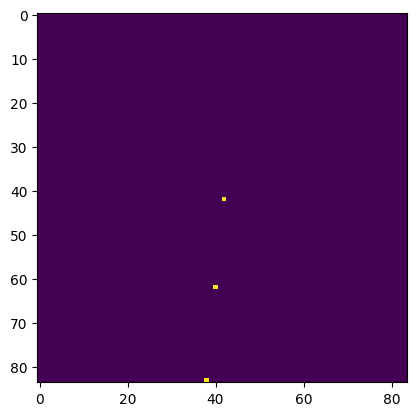

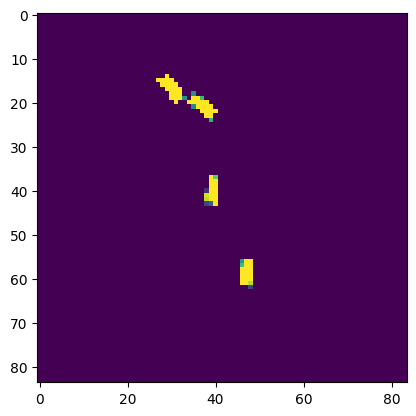

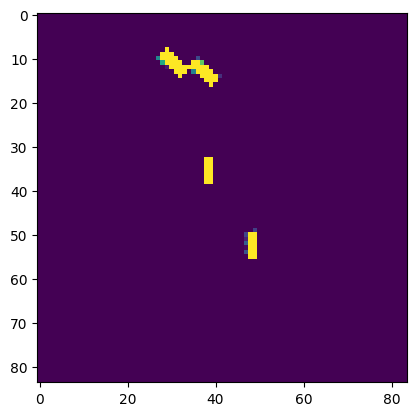

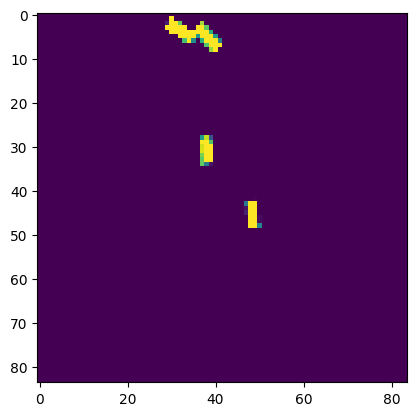

In [51]:
obs_example = obs[-1].transpose(2, 0, 1)

# obs_example has shape (5, 84, 84)
# plot each channel separately
for i in range(5):
    plt.imshow(obs_example[i])
    plt.show()
